In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import *
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import seaborn

In [3]:
#just looking to verify that changes in a players reward are precisely changes in the potential function

#empirically the sum seems to work

In [15]:
#functions 

def player_return(utility_func, plays, system_vals, pi_cp):
    indicator_vec = vec_softmax(system_vals)
    cp_cost = np.sum(pi_cp*(plays*indicator_vec))
    rev = np.sum(utility_func(plays))
    out = rev - cp_cost
    return(out)

def vec_softmax(system_vals, beta=10):
    #system_vals must be numpy array
    if type(np.array([1])) != np.ndarray:
        print("System values not numpy array")
    else:
        #large beta approximates argmax indicator vector
        numer = np.exp(beta*system_vals)
        denom = np.sum(np.exp(beta*system_vals))
        out = (1.0/denom)*numer
        return(out)
    
def player_utility_lambda(a=1):
    return(lambda x: a*np.log(1 + x))

In [16]:
p1 = player_utility_lambda(a=1)
p2 = player_utility_lambda(a=2)
p3 = player_utility_lambda(a=5)

plays_1 = np.array([1,2,5])
plays_2 = np.array([1,2,5])
plays_3 = np.array([1,2,5])
sys_vals = plays_1 + plays_2 + plays_3

print(sys_vals)

[ 3  6 15]


In [26]:
p1_r = player_return(p1, plays_1, sys_vals, 0.5)
p2_r = player_return(p2, plays_2, sys_vals, 0.5)
p3_r = player_return(p3, plays_3, sys_vals, 0.5)

sum_r = p1_r + p2_r + p3_r

print("player rewards: ", p1_r, p2_r, p3_r)

print("sum: ", sum_r)

player rewards:  1.08351893845611 4.66703787691222 15.417594692280552
sum:  21.168151507648883


In [27]:
plays_3_delta = plays_3 - np.array([0,-7,2.9])

sys_vals_delta = plays_1 + plays_2 + plays_3_delta
print(sys_vals_delta)

p1_r_d = player_return(p1, plays_1, sys_vals_delta, 0.5)
p2_r_d = player_return(p2, plays_2, sys_vals_delta, 0.5)
p3_r_d = player_return(p3, plays_3_delta, sys_vals_delta, 0.5)

sum_r_d = p1_r_d + p2_r_d + p3_r_d

print("player rewards: ", p1_r_d, p2_r_d, p3_r_d)
print("player 3 updated plays: ", plays_3_delta)
print("updated sum: ", sum_r_d)

[ 3.  13.  12.1]
player rewards:  2.5833338465921307 6.16685278504824 16.136097636512613
player 3 updated plays:  [1.  9.  2.1]
updated sum:  24.886284268152984


In [28]:
print("player 3: ", p3_r_d - p3_r)
print("sum: ", sum_r_d - sum_r)

player 3:  0.7185029442320605
sum:  3.7181327605041012


In [35]:
p3rewards = []
sumrewards = []

for i in np.arange(-20,20,0.1):
    plays_3_delta = plays_3 - np.array([0,0,i])

    sys_vals_delta = plays_1 + plays_2 + plays_3_delta
    #print(np.argmax(sys_vals_delta))
    #print(sys_vals_delta)

    p1_r_d = player_return(p1, plays_1, sys_vals_delta, 0.5)
    p2_r_d = player_return(p2, plays_2, sys_vals_delta, 0.5)
    p3_r_d = player_return(p3, plays_3_delta, sys_vals_delta, 0.5)

    sum_r_d = p1_r_d + p2_r_d + p3_r_d

    print("player rewards: ", p1_r_d, p2_r_d, p3_r_d)
    print("player 3 updated plays: ", plays_3_delta)
    print("updated sum: ", sum_r_d)
    
    p3rewards.append(p3_r_d)
    sumrewards.append(sum_r_d)

player rewards:  1.08351893845611 4.66703787691222 12.749280036247686
player 3 updated plays:  [ 1.  2. 25.]
updated sum:  18.499836851616017
player rewards:  1.08351893845611 4.66703787691222 12.780012189667737
player 3 updated plays:  [ 1.   2.  24.9]
updated sum:  18.530569005036067
player rewards:  1.08351893845611 4.66703787691222 12.810669805778137
player 3 updated plays:  [ 1.   2.  24.8]
updated sum:  18.561226621146467
player rewards:  1.08351893845611 4.66703787691222 12.841252305646147
player 3 updated plays:  [ 1.   2.  24.7]
updated sum:  18.591809121014478
player rewards:  1.08351893845611 4.66703787691222 12.871759103567861
player 3 updated plays:  [ 1.   2.  24.6]
updated sum:  18.62231591893619
player rewards:  1.0835189384561104 4.66703787691222 12.902189606962184
player 3 updated plays:  [ 1.   2.  24.5]
updated sum:  18.652746422330516
player rewards:  1.08351893845611 4.66703787691222 12.932543216262733
player 3 updated plays:  [ 1.   2.  24.4]
updated sum:  18.683

player 3 updated plays:  [1.  2.  8.2]
updated sum:  21.70537158178357
player rewards:  1.08351893845611 4.66703787691222 15.950169413754285
player 3 updated plays:  [1.  2.  8.1]
updated sum:  21.700726229122616
player rewards:  1.08351893845611 4.66703787691222 15.94492023282136
player 3 updated plays:  [1. 2. 8.]
updated sum:  21.69547704818969
player rewards:  1.08351893845611 4.66703787691222 15.939053729830729
player 3 updated plays:  [1.  2.  7.9]
updated sum:  21.68961054519906
player rewards:  1.08351893845611 4.66703787691222 15.932555953561064
player 3 updated plays:  [1.  2.  7.8]
updated sum:  21.683112768929394
player rewards:  1.0835189384561104 4.66703787691222 15.925412474442947
player 3 updated plays:  [1.  2.  7.7]
updated sum:  21.675969289811277
player rewards:  1.08351893845611 4.66703787691222 15.91760836243757
player 3 updated plays:  [1.  2.  7.6]
updated sum:  21.6681651778059
player rewards:  1.08351893845611 4.66703787691222 15.909128163621606
player 3 updat

player rewards:  2.583518938456157 6.167037876912267 nan
player 3 updated plays:  [  1.    2.  -12.7]
updated sum:  nan
player rewards:  2.583518938456157 6.167037876912267 nan
player 3 updated plays:  [  1.    2.  -12.8]
updated sum:  nan
player rewards:  2.583518938456157 6.167037876912267 nan
player 3 updated plays:  [  1.    2.  -12.9]
updated sum:  nan
player rewards:  2.583518938456157 6.167037876912267 nan
player 3 updated plays:  [  1.   2. -13.]
updated sum:  nan
player rewards:  2.583518938456157 6.167037876912267 nan
player 3 updated plays:  [  1.    2.  -13.1]
updated sum:  nan
player rewards:  2.583518938456157 6.167037876912267 nan
player 3 updated plays:  [  1.    2.  -13.2]
updated sum:  nan
player rewards:  2.583518938456157 6.167037876912267 nan
player 3 updated plays:  [  1.    2.  -13.3]
updated sum:  nan
player rewards:  2.583518938456157 6.167037876912267 nan
player 3 updated plays:  [  1.    2.  -13.4]
updated sum:  nan
player rewards:  2.583518938456157 6.167037

/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in log


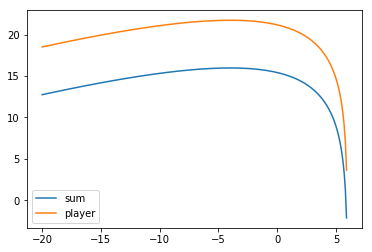

In [40]:
plt.plot(np.arange(-20,20,0.1), p3rewards, label="sum")
plt.plot(np.arange(-20,20,0.1), sumrewards, label="player")
plt.legend()
plt.show()

nan